In [94]:
import numpy as np
import netCDF4
import subprocess
from operator import itemgetter
import gsw
from matplotlib import pyplot as plt

# read the database of argo profile data as set up
cur_dir = subprocess.check_output("pwd", shell=True)[:-1]
dest_dir = cur_dir + "/jerupiga/"
dbase = np.load(dest_dir + "argo_profile_info_database.npz")["dbase"]

In [142]:
print len(dbase)
match = dbase[dbase["ps_qc"] != 'F']
print len(match)
match = match[match["ps_qc"] != 'E']
print len(match)
match = match[match["ps_qc"] != 'D']
print len(match), len(match[np.logical_or(match["pt_qc"] == 'E', match["pt_qc"] == 'F')]), len(match[match["pt_qc"]=="F"])
# match = match[np.logical_or(match["pt_qc"] != 'F', match["pt_qc"] != 'E')]
match = match[match["pt_qc"] != 'F']
print len(match), len(match[np.logical_or(match["pt_qc"] == 'D', match["pp_qc"] == 'F')]), len(match[match["pp_qc"]=="E"])
# match = dbase[np.logical_and(dbase["lon"] >= 75., dbase["lon"] <= 85.)]
match = match[np.logical_and(match["lon"] >= 78., match["lon"] <= 82.)]
match = match[np.logical_and(match["lat"] <= -6., match["lat"] >= -10.)]
# match = match[np.logical_or(match["month"] <= 4, match["month"] >= 11)]
print len(match)
match = match[np.logical_and(match["pmin"] <= 50., match["pmax"] >= 200.)]
# match = match[np.logical_or(match["pt_qc"] != "D", match["ps_qc"] != "D")]
print len(match)

17486
15897
15886
15881 2 2
15879 0 0
626
626


/home/saulo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater_equal
/home/saulo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in less_equal


In [143]:
daids = list(set(match["floatid"]))  # has to be same as filestoread, could come before pathstofile
pathstofiles = [dest_dir + m + "_prof.nc" for m in daids]

In [144]:
print len(match), len(daids), len(dbase)
print len(dbase[dbase["ps_qc"] == 'F'])
print len(dbase) - len(dbase[dbase["ps_qc"] == 'F']) - len(dbase[dbase["ps_qc"] == 'E']) - len(dbase[dbase["ps_qc"] == 'D'])

626 33 17486
1589
15881


In [145]:
def fillup_argolist():
    argo_profs = []
    append = argo_profs.append
    for n in range(0, len(daids)):
        argo_data = netCDF4.Dataset(pathstofiles[n])
        #  argo_data = netCDF4.Dataset(filestoread[n])
        prof_idxs = match[match["floatid"]==daids[n]]["prof_n"]
        # start pulling off data, should go all into some container class type (which would have limited functionality):
        juld = argo_data.variables['JULD'][prof_idxs]  # at the moment contains multiple profiles
        juld_qc = argo_data.variables['JULD_QC'][prof_idxs]
        juld_loc = argo_data.variables['JULD_LOCATION'][prof_idxs]
        lat = argo_data.variables['LATITUDE'][prof_idxs]
        lon = argo_data.variables['LONGITUDE'][prof_idxs]
        pos_qc = argo_data.variables['POSITION_QC'][prof_idxs]
        prof_pres_qc = argo_data.variables['PROFILE_PRES_QC'][prof_idxs]
        prof_sal_qc = argo_data.variables['PROFILE_PSAL_QC'][prof_idxs]
        prof_temp_qc = argo_data.variables['PROFILE_TEMP_QC'][prof_idxs]
        pres = argo_data.variables['PRES'][prof_idxs, :]
        pres_qc = argo_data.variables['PRES_QC'][prof_idxs, :]
        pres_a = argo_data.variables['PRES_ADJUSTED'][prof_idxs, :]
        pres_a_qc = argo_data.variables['PRES_ADJUSTED_QC'][prof_idxs, :]
        pres_a_er = argo_data.variables['PRES_ADJUSTED_ERROR'][prof_idxs, :]
        sal = argo_data.variables['PSAL'][prof_idxs, :]
        sal_qc = argo_data.variables['PSAL_QC'][prof_idxs, :]
        sal_a = argo_data.variables['PSAL_ADJUSTED'][prof_idxs, :]
        sal_a_qc = argo_data.variables['PSAL_ADJUSTED_QC'][prof_idxs, :]
        sal_a_er = argo_data.variables['PSAL_ADJUSTED_ERROR'][prof_idxs, :]
        temp = argo_data.variables['TEMP'][prof_idxs, :]
        temp_qc = argo_data.variables['TEMP_QC'][prof_idxs, :]
        temp_a = argo_data.variables['TEMP_ADJUSTED'][prof_idxs, :]
        temp_a_qc = argo_data.variables['TEMP_ADJUSTED_QC'][prof_idxs, :]
        temp_a_er = argo_data.variables['TEMP_ADJUSTED_ERROR'][prof_idxs, :]
        min_p = pres.min(axis=-1)
        max_p = pres.max(axis=-1)
        argo_data.close()
        
        # storing these data in arrays or lists? something that will allow easy further querying and sorting
        for k in range(0, len(prof_idxs)):
            # derived variables:
            SA = gsw.SA_from_SP(sal[k], pres[k], lon[k], lat[k])
            CT = gsw.CT_from_t(SA, temp[k], pres[k])
            Theta = gsw.pt0_from_t(SA, temp[k], pres[k])
            Nsq, p_mid, Nsq_b, Nsq_a = gsw.Nsquared(SA, CT, pres[k], lat[k]) # needs remasking
            sig_theta = gsw.rho(SA, CT, 0) # potential density referenced to 0, using one scheme 
            #sig_theta_2 = gsw.sigma0_pt0_exact(SA, Theta) # potential density ref to 0db but using Theta, slightly different
            #rho, Alpha, Beta = gsw.rho_alpha_beta(SA, CT, pres)
            
            append([juld[k], lat[k], lon[k], juld_qc[k], pos_qc[k], min_p[k], max_p[k],
                    prof_pres_qc[k], prof_sal_qc[k], prof_temp_qc[k], pres[k], pres_qc[k],
                    pres_a[k], pres_a_qc[k], pres_a_er[k], sal[k], sal_qc[k], sal_a[k],
                    sal_a_qc[k], sal_a_er[k], temp[k], temp_qc[k], temp_a[k], temp_a_qc[k],
                    temp_a_er[k], SA, CT, Theta, sig_theta, Nsq, Nsq_b, Nsq_a, p_mid])  # is a list of profiles, in fact a list of a list of prof properties
    return argo_profs
argo_profs = fillup_argolist()

In [93]:
print argo_profs[0][5], argo_profs[0][6], argo_profs[0][9]
np.logical_or?

8.0 1982.0 A


In [ ]:
argo_profiles_time = sorted(argo_profs, key=itemgetter(0))  # sort list by time

In [72]:
print pathstofiles[0], daids[0]
print match[0], dbase[0]
dbase.dtype

/home/saulo/projects/data/ARGO_profiles/central_tsio/jerupiga/2900426_prof.nc 2900426
('1900160', 88, 71, 2005, 4, 7, 20185.720703125, -3.2009999752044678, 78.54299926757812, 3102.199951171875, 3102.199951171875, 1, 1, 62) ('1900160', 88, 71, 2003, 6, 26, 19534.783203125, 6.171999931335449, 52.44900131225586, 4.099999904632568, 848.5, 1, 1, 0)


dtype([('floatid', 'S21'), ('nprofs', '<i4'), ('nlevs', '<i4'), ('year', '<i4'), ('month', '<i4'), ('day', '<i4'), ('juld', '<f4'), ('lat', '<f4'), ('lon', '<f4'), ('pmin', '<f4'), ('pmax', '<f4'), ('jul_qc', '<i4'), ('pos_qc', '<i4'), ('prof_n', '<i4')])

In [163]:
N2, pmid = argo_profs[0][-4], argo_profs[0][-1]
pmin = zip(*argo_profs)[5]
pmax = zip(*argo_profs)[6]
ppqc = zip(*argo_profs)[7]
lats = zip(*argo_profs)[1]
lons = zip(*argo_profs)[2]

from matplotlib.dates import datestr2num, num2date
ref_date_num = datestr2num("1950-01-01") 
juld = map(ref_date_num .__add__, zip(*argo_profs)[0])

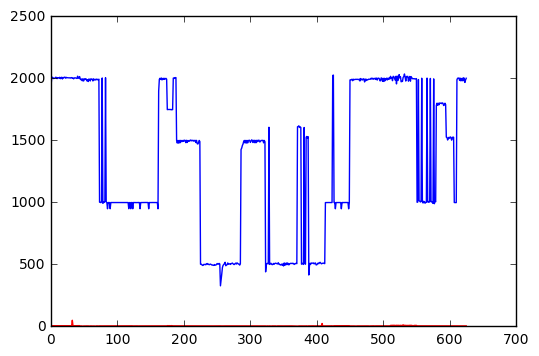

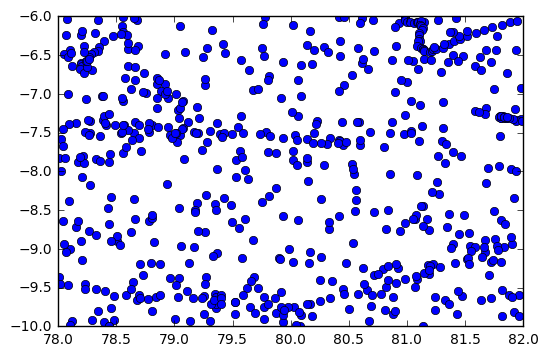

-7.6265 80.0135002136


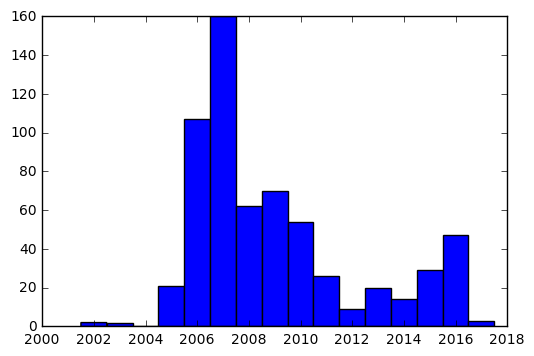

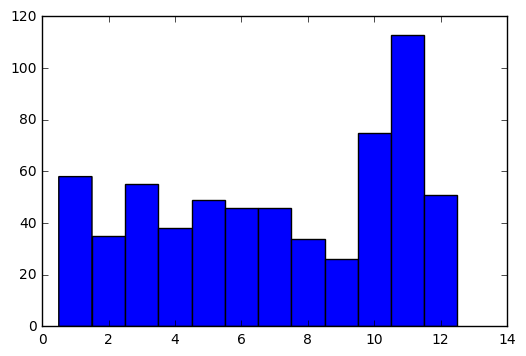

In [182]:
from matplotlib import pyplot as plt
%matplotlib inline
#plt.figure()
#plt.plot(N2,-pmid)
#plt.show()
#print np.min(N2)
plt.figure()
plt.plot(pmax, 'b')
plt.plot(pmin, 'r')
plt.show()
plt.figure()
plt.plot(lons, lats, 'o')
plt.show()
print np.median(lats), np.median(lons)
plt.figure()
plt.hist(map(lambda x:x.year, num2date(juld)), bins=np.arange(2002, 2019), align="left")
plt.show()
plt.figure()
plt.hist(map(lambda x:x.month, num2date(juld)), bins=np.arange(1,14), align="left")
plt.show()
# juld[map(lambda x:x.month, num2date(juld)) == 12]
# plt.figure(), plt.plot(map(lambda x:x.month, num2date(juld))), plt.show()

In [194]:
months = np.array(np.array(map(lambda x:x.month, num2date(juld))))
years = np.array(map(lambda x:x.year, num2date(juld)))

(array([ 0.,  0.,  2.,  1.,  3.,  3.,  3.,  1.,  0.,  0.,  0.,  1.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 12 Patch objects>)

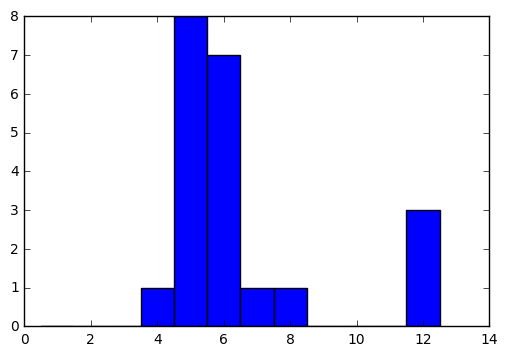

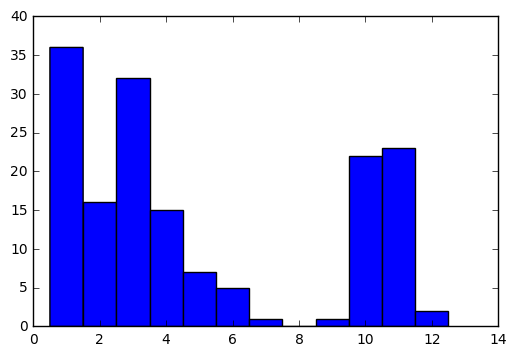

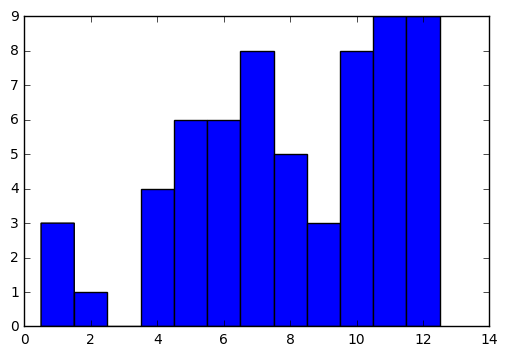

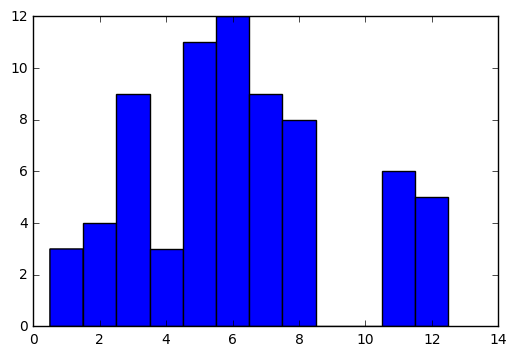

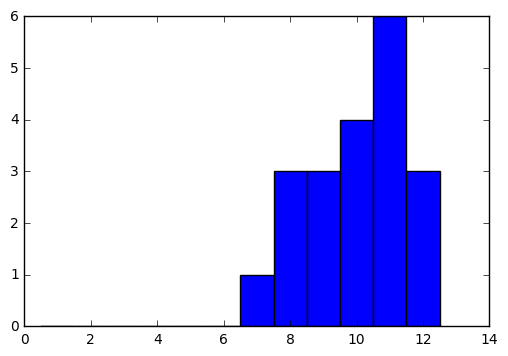

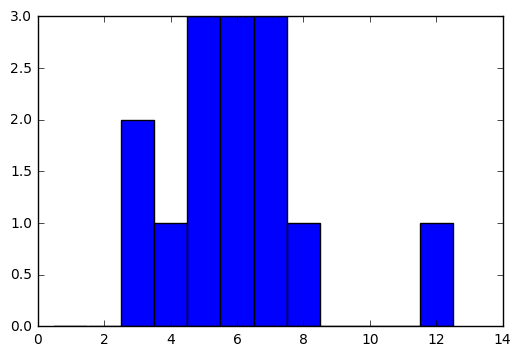

In [202]:
plt.figure()
plt.hist(months[years == 2005], bins=np.arange(1,14), align="left")
plt.figure()
plt.hist(months[years == 2007], bins=np.arange(1,14), align="left")
plt.figure()
plt.hist(months[years == 2008], bins=np.arange(1,14), align="left")
plt.figure()
plt.hist(months[years == 2009], bins=np.arange(1,14), align="left")
plt.figure()
plt.hist(months[years == 2013], bins=np.arange(1,14), align="left")
plt.figure()
plt.hist(months[years == 2014], bins=np.arange(1,14), align="left")
#plt.figure()
#plt.hist(months[years == 2010], bins=np.arange(1,14), align="left")
#print months[years == 2010], len(months[years == 2010])
#plt.figure()
#plt.hist(months[years == 2011], bins=np.arange(1,14), align="left")
#plt.figure()
#plt.hist(months[years == 2016], bins=np.arange(1,14), align="left")

In [ ]:
depth = gsw.
dz = np.diff(depth)
z_top = depth[1:] - dz/2.
thickness = np.diff(z_top)
thickness = np.concatenate((np.array([z_top[0]]), thickness,
                            np.array([thickness[-1]]))) # this is thickness of bins centered at depth

dThetadz = np.gradient(Theta, axis=1) / thickness[None, :, None, None]
dCTdz = np.gradient(CT, axis=1) / thickness[None, :, None, None]
dSAdz = np.gradient(SA, axis=1) / thickness[None, :, None, None]
Nsq_T = 9.81 * Alpha * dCTdz
Nsq_theta = 9.81 * Alpha * dThetadz
Nsq_SA = 9.81 * Beta * dSAdz
mld